## Context-awareness analyses
This section aims to inderstand how participants adjusted their contextual assessment of safety versus threat 
- over time 
- as a function of true cases 
- as a function of peak threat 
- as a function of trait anxiety 


In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import numpy as np
import os
import pandas as pd
from cov_functions import *
import matplotlib.patches as mpatches

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import bambi as bmb
import arviz as az



warnings.filterwarnings('ignore')
print('\n'.join(f'{m.__name__} {m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))


numpy 1.20.2
pandas 1.3.3
seaborn 0.11.0
bambi 0.7.1
arviz 0.11.4
/data/drive/postdoc/Project4_covid/covid-fear/scripts


In [2]:
# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
df["submitdate"] = pd.to_datetime(df["submitdate"])
#df=df.loc[df["GROUP"].isin(["UK"])]

### Safety/threat over time

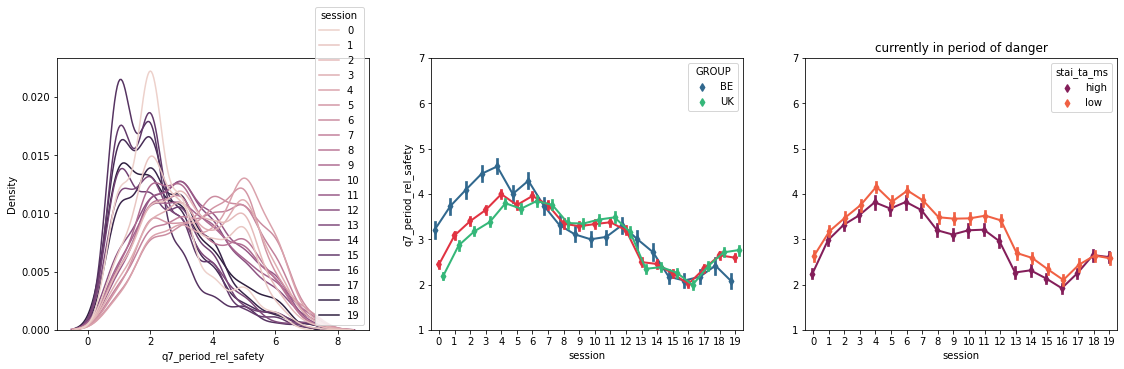

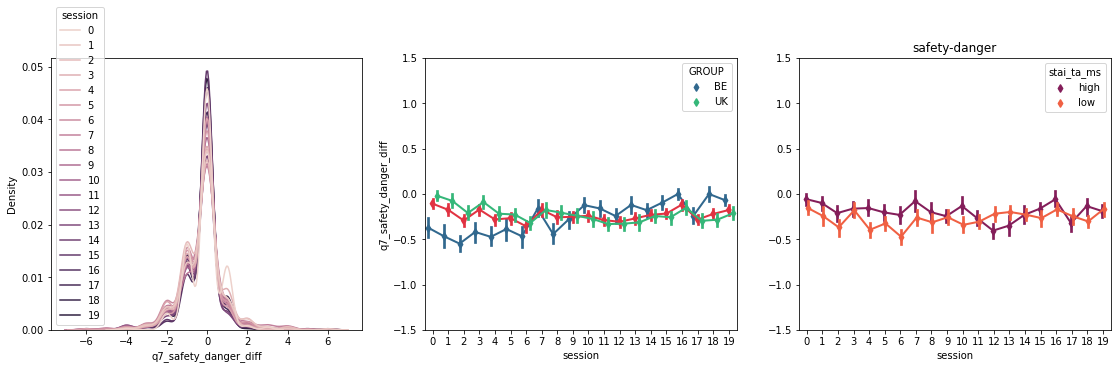

In [3]:
var = ["q7_period_rel_danger", "q7_period_rel_safety", "q7_safety_danger_diff"]
lbl = ["currently in period of danger", "currently in period of safety", "safety-danger"]

for vidx, v in enumerate(var):
    fig, axs = plt.subplots(ncols=3, figsize=(19,5))
    g = sns.kdeplot(data=df, x=v, hue="session",  common_norm=True, ax=axs[0])#, multiple="fill")
    plt.xlabel(lbl[vidx]);
    
    pal = sns.color_palette("rocket")
    sns.pointplot(x="session", y=v,
                  data=df, dodge=.532, join=True, color=pal[3],
                  markers="d", scale=.75, ci=68, ax=axs[1]);
    sns.pointplot(x="session", y=v, hue="GROUP",
                  data=df, dodge=.532, join=True, palette=sns.color_palette("viridis",2),
                  markers="d", scale=.75, ci=68, ax=axs[1]);
    plt.title(lbl[vidx]);
    if v == "q7_safety_danger_diff":
        axs[1].set_ylim((-1.5,1.5))
    else:
        axs[1].set_ylim((1,7))
    
    
    
    #anxiety
    sns.pointplot(x="session", y=v, hue="stai_ta_ms",
                  data=df, dodge=.1, join=True, palette=sns.color_palette("rocket",2),
                  markers="d", scale=.75, ci=68, ax=axs[2]);
    plt.title(lbl[vidx]);
    plt.ylabel("")
    if v == "q7_safety_danger_diff":
        plt.ylim((-1.5,1.5))
    else:
        plt.ylim((1,7))

### Safety/threat by true cases

> Mathieu, E., Ritchie, H., Ortiz-Ospina, E. et al. A global database of COVID-19 vaccinations. Nat Hum Behav (2021). https://doi.org/10.1038/s41562-021-01122-8

In [4]:
# covid data from Our world in Data: https://github.com/owid/covid-19-data
# csv location https://covid.ourworldindata.org/data/owid-covid-data.csv

extra = 0
if extra==1:
    covcase = pd.read_csv(os.path.join(root_dir, "data", "owid-covid-data.csv"))
    covcase = covcase.loc[covcase["iso_code"].isin(["DEU", "GBR"]),:]
    covcase['date'] = pd.to_datetime(covcase['date'])
    start_date = '01-01-2020'
    end_date = '31-12-2020'
    ids = (covcase['date'] > start_date) & (covcase['date'] <= end_date)
    covcase = covcase.loc[ids]
    ccase = pd.DataFrame()
    for c in ["DEU", "GBR"]:
        #select data for a give country
        dfi = covcase.loc[covcase["iso_code"]==c,]
        # calculate rolling mean 
        dfi["cases7"] = dfi["new_cases"].rolling(7).mean()
        dfi["deaths7"] = dfi["new_deaths"].rolling(7).mean()
        # merge 
        ccase = pd.concat([ccase, dfi])
    ccase["GROUP"] = ccase["iso_code"].replace({"DEU": "BE", "GBR": "UK"})
    ccase["submitdate"] = ccase["date"]
    covcase = ccase.loc[:,["GROUP", "submitdate", "cases7", "deaths7"]]


    ## finally, append the folling mean of cases to the main df
    df = df.merge(covcase, on=["submitdate", "GROUP"], how="left")



#### Number of covid cases and deaths

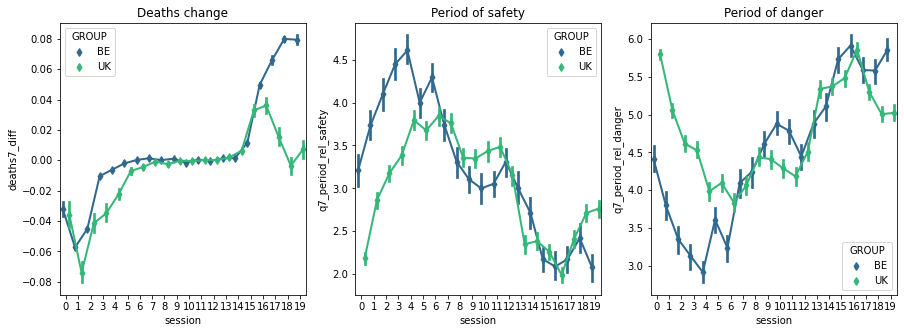

In [5]:
var = ["cases7_diff", "deaths7_diff"]
lbl = ["Cases change ","Deaths change"]

for vidx, v in enumerate(var):
    fig, axs = plt.subplots(ncols=3, figsize=(15,5))   
    pal = sns.color_palette("rocket")
    sns.pointplot(x="session", y=v, hue="GROUP",
                  data=df, dodge=.532, join=True, palette=sns.color_palette("viridis",2),
                  markers="d", scale=.75, ci=68, ax=axs[0]).set_title(lbl[vidx]);
    sns.pointplot(x="session", y="q7_period_rel_safety", hue="GROUP",
                  data=df, dodge=.532, join=True, palette=sns.color_palette("viridis",2),
                  markers="d", scale=.75, ci=68, ax=axs[1]).set_title("Period of safety")
    sns.pointplot(x="session", y="q7_period_rel_danger", hue="GROUP",
                  data=df, dodge=.532, join=True, palette=sns.color_palette("viridis",2),
                  markers="d", scale=.75, ci=68, ax=axs[2]).set_title("Period of danger")
    


#### Relationship between perceived danger and true number of cases/deaths

In [6]:
import statsmodels.api as sm
import scipy as sc
d = df.loc[:,["session","deaths7_diff", "cases7_diff", "q7_period_rel_danger"]]
d = d.groupby(by="session", dropna=False).mean()

color = 'tab:red'
color2 = 'tab:blue'
nicelabels = ["Avg cases over previous 7 days", "Avg deaths over previous 7 days"]
plt.rcParams.update({'font.size': 14})
for vidx, v in enumerate(["cases7_diff", "deaths7_diff"]):
    fig, ax1 = plt.subplots(nrows=2, figsize=(6,8))
    
    q = np.array([])
    ci = np.empty((2,20))
    ci[:] = np.NaN
    for s in range(20):
        dfl = df.loc[df["sess_str"]=="sess"+str(s),[v, "q7_period_rel_danger"]]
        dfl.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Drop rows with NaN
        dfl.dropna(inplace=True)
        #mod = sm.OLS(preprocessing.scale(dfl["cases7"]),dfl["q7_period_rel_danger"])
        r,p,ci[0][s],ci[1][s] = pearsonr_ci(dfl[v],dfl["q7_period_rel_danger"])
        q= np.append(q,r)
    ax1[0].set_ylabel(nicelabels[vidx], color=color)
    ax1[0].plot(d[v], color=color) 
    ax1[0].tick_params(axis='y', labelcolor=color)
    ax2 = ax1[0].twinx() 

    ax2.set_ylabel('Perceived relative danger', color=color2)  # we already handled the x-label with ax1
    ax2.plot(d["q7_period_rel_danger"], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    ax1[1].plot(q, color='g', linewidth=2) 
    ax1[1].plot(ci[0][:], color='g', linestyle='dashed', alpha=0.3) 
    ax1[1].plot(ci[1][:], color='g', linestyle='dashed', alpha=0.3) 
    ax1[1].set_title('Corr b/w objective and perceived danger', color="g")  # we already handled the x-label with ax1
    
    plt.title("Perception of danger and objective "+ v)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


#### Trait Anxiety

In [7]:
d = df.loc[:,["session","stai_ta_ms", "deaths7", "cases7", "q7_period_rel_danger"]]
d = d.groupby(by=["session", "stai_ta_ms"], dropna=False).mean().reset_index()

for vidx, v in enumerate(["cases7", "deaths7"]):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,12))
    for aidx, anx in enumerate(["low", "high"]):

        q = np.array([])
        ci = np.empty((2,20))
        ci[:] = np.NaN
        for s in range(20):
            
            dfl = df.loc[((df["stai_ta_ms"].isin([anx])) & (df["session"]==s)  ),[v, "q7_period_rel_danger"]]
            dfl.replace([np.inf, -np.inf], np.nan, inplace=True)
            # Drop rows with NaN
            dfl.dropna(inplace=True)
            #mod = sm.OLS(preprocessing.scale(dfl["cases7"]),dfl["q7_period_rel_danger"])
            r,p,ci[0][s],ci[1][s] = pearsonr_ci(dfl[v],dfl["q7_period_rel_danger"])
            q= np.append(q,r)
        dloc = d.loc[d["stai_ta_ms"].isin([anx]),].reset_index()
        ax[0, aidx].set_ylabel(nicelabels[vidx], color=color)
        ax[0, aidx].plot(dloc[v], color=color) 
        ax[0, aidx].tick_params(axis='y', labelcolor=color)
        ax2 = ax[0,aidx].twinx() 

        ax2.set_ylabel('Perceived relative danger', color=color2)  # we already handled the x-label with ax1
        ax2.plot(dloc["q7_period_rel_danger"], color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

        ax[1,aidx].plot(q, color='g', linewidth=2) 
        ax[1,aidx].plot(ci[0][:], color='g', linestyle='dashed', alpha=0.3) 
        ax[1,aidx].plot(ci[1][:], color='g', linestyle='dashed', alpha=0.3) 
        ax[1,aidx].set_title('Corr b/w objective and perceived danger', color="g")  # we already handled the x-label with ax1

        plt.title(anx + " anxiety ("+ v +")")

#d.loc[d["stai_ta_ms"].isin([anx])].reset_index()
#,["q7_period_rel_danger"]].reset_index()

KeyError: "['deaths7', 'cases7'] not in index"

#### Regression Anxiety
- doesn't seem to do too well

In [ ]:
import statsmodels.formula.api as smf
ci = np.empty((20,3,2))
ci[:] = np.NaN
results = smf.ols('q7_period_rel_danger ~ deaths7 * stai_ta_s1', data=df).fit()
ci[:][:][1] = results.conf_int()[1:4]

In [ ]:
eq = ["q7_period_rel_danger ~ cases7 * stai_ta_s1", "q7_period_rel_danger ~ deaths7 * stai_ta"]
for vidx, v in enumerate(["cases7", "deaths7"]):
    m = np.empty((3,20))
    m[:] = np.NaN
    ci = np.empty((3,2,20))
    ci[:] = np.NaN
    for s in range(20):
        dfl = df.loc[df["sess_str"]=="sess"+str(s),[v, "q7_period_rel_danger", "stai_ta"]]
        dfl.replace([np.inf, -np.inf], np.nan, inplace=True)
        # Drop rows with NaN
        #dfl.dropna(inplace=True)    
        results = smf.ols('q7_period_rel_danger ~ '+v+' * stai_ta', data=dfl).fit()
        ci[:,:,s] = results.conf_int()[1:4]
        m[:,s] = results.params[1:4]

        
    t=np.arange(20)
    fig, ax = plt.subplots(ncols=3, figsize=(13,4))
    regnames = [v, "anxiety", v+"*anxiety"]
    for r in range(3):
        ax[r].plot(t, m[r,:], lw=2, color='blue')
        ax[r].fill_between(t, m[r,:]+ci[r,0,:], m[r,:]+ci[r,1,:], facecolor='blue', alpha=0.2)
        ax[r].set_title(regnames[r])




### Peak locking data 

In [ ]:
tdf = df[["session", "covid_worry", "PROLIFICID"]]
tdf = tdf.pivot(index='PROLIFICID', columns='session', values="covid_worry").add_prefix('sess').dropna()
import scipy as sc
tdf.iloc[0,:].plot()
x = tdf.iloc[0,:]
peaks, _ = sc.signal.find_peaks(x, prominence=5, width=1)
plt.plot(x)
plt.plot(peaks, x[peaks], "x", linewidth=2)